In [1]:
import os, glob, math, json
import numpy as np
import pandas as pd
import tensorflow as tf

from PIL import Image
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
print (tf.__version__)

2.1.0


# 0. Data Pre-analysis

In [3]:
train_width, train_height = [], []
train_channel = set()

In [4]:
for prog in os.listdir('dataset'):
    for fname in glob.glob(os.path.join('dataset', prog, '*.png')):
        im = Image.open(fname)
        w, h = im.size
        train_width.append(w)
        train_height.append(h)
        train_channel.add(im.getbands())
assert len(train_width) == len(train_height), "# Mismatch between N# height and width!"

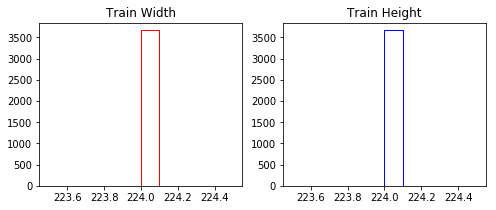

In [5]:
fig = plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.title('Train Width')
plt.hist(train_width, color='red', label='Width', histtype='step')
plt.subplot(1, 2, 2)
plt.title('Train Height')
plt.hist(train_height, color='blue', label='Height', histtype='step')
plt.show()

In [6]:
print ('Image Channel: ', train_channel)

Image Channel:  {('L',)}


In [7]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
INPUT_SIZE = (IMG_HEIGHT, IMG_WIDTH)

In [8]:
print ("Getting Training Data")
trainGenerator = tf.keras.preprocessing.image.ImageDataGenerator(
                rescale=1./255, 
                rotation_range=30,
                zoom_range=0.15,
                width_shift_range=0.15, 
                height_shift_range=0.15, 
                horizontal_flip=True,
                vertical_flip=True,
                validation_split=0.2
                )

print ("Subsampling Training Set")
train_data = trainGenerator.flow_from_directory(
                    batch_size=BATCH_SIZE,
                    directory='dataset',
                    #target_size=INPUT_SIZE,
                    subset='training',)
#                     color_mode='grayscale')
num_train_data = train_data.n

print ("Subsampling Validation Set")
val_data = trainGenerator.flow_from_directory(
                    batch_size=BATCH_SIZE,
                    directory='dataset',
                    #target_size=INPUT_SIZE,
                    subset='validation',)
                    #color_mode='grayscale')
num_val_data = val_data.n

labels = {z: dis for z, dis in enumerate(os.listdir('dataset'))}
print ("Labels: ", labels)

Getting Training Data
Subsampling Training Set
Found 2931 images belonging to 5 classes.
Subsampling Validation Set
Found 731 images belonging to 5 classes.
Labels:  {0: 'Mild', 1: 'No_DR', 2: 'Proliferate_DR', 3: 'Moderate', 4: 'Severe'}


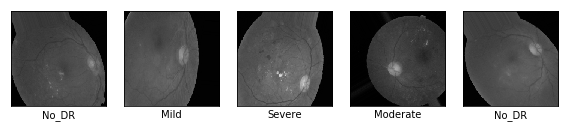

In [9]:
def decodeOneHot(one_hot_vector):
    return np.argmax(one_hot_vector)

def plotImages(images_arr, label_arr):
    """
    Displays a selection of images (e.g. from training dataset)
    with their appropriate labels.
    Input: array_of_images[n], 
        where n takes the form of array slicer.
    Output: plot(s) of rescaled images with their curated annotation.
    """
    fig, axes = plt.subplots(1, 5, figsize=(8,8))
    axes = axes.flatten()
    for img, dataLabel, ax in zip(images_arr, label_arr, axes):
        img = np.asarray(img)
        ax.imshow(img)#, cmap='gray')
        ax.set_xlabel(labels[decodeOneHot(dataLabel)])
        ax.set_yticks([])
        ax.set_xticks([])
    plt.tight_layout()
    plt.show()


sample_train, label = next(train_data)
plotImages(sample_train[:5], label[:5])

In [70]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu',
                           input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(3, strides=2),
    tf.keras.layers.Dropout(0.2, seed=111),
    
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
#     tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(3, strides=2),
    tf.keras.layers.Dropout(0.2, seed=111),
    
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(3, strides=2),
    tf.keras.layers.Dropout(0.2, seed=111),
    
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(3, strides=2),
    tf.keras.layers.Dropout(0.2, seed=111),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.4, seed=111),
    tf.keras.layers.Dense(5, activation='softmax')
    ])
model.compile(optimizer=tf.keras.optimizers.Adam(epsilon=1e-3, ),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'AUC', 'Precision', 'Recall'])
model.summary()
now = datetime.strftime(datetime.today(), '%Y%m%d_%H%M')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 127, 127, 64)      18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 63, 63, 128)      

In [71]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)

LR_reduce = tf.keras.callbacks.ReduceLROnPlateau(
                            monitor='val_accuracy', 
                            patience=5, 
                            verbose=1, 
                            factor=2/3, 
                            min_lr=1e-5)
callbacks = [early_stop, LR_reduce]

In [72]:
# with tf.device('/gpu:0'):
history = model.fit(train_data, 
                    steps_per_epoch=math.ceil(num_train_data/BATCH_SIZE), 
                    epochs=50,
                    validation_data=val_data,
                    callbacks=callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 92 steps, validate for 23 steps
Epoch 1/50
92/92 [==============================] - 39s 422ms/step - loss: 1.2961 - accuracy: 0.4968 - AUC: 0.7778 - Precision: 0.5862 - Recall: 0.2064 - val_loss: 1.3944 - val_accuracy: 0.5116 - val_AUC: 0.7908 - val_Precision: 1.0000 - val_Recall: 0.0041
Epoch 2/50
92/92 [==============================] - 38s 411ms/step - loss: 1.1549 - accuracy: 0.5640 - AUC: 0.8249 - Precision: 0.7304 - Recall: 0.3569 - val_loss: 1.1711 - val_accuracy: 0.5869 - val_AUC: 0.8491 - val_Precision: 0.9061 - val_Recall: 0.2244
Epoch 3/50
92/92 [==============================] - 37s 407ms/step - loss: 1.0572 - accuracy: 0.6203 - AUC: 0.8556 - Precision: 0.7559 - Recall: 0.4374 - val_loss: 1.0603 - val_accuracy: 0.5855 - val_AUC: 0.8577 - val_Precision: 0.7391 - val_Recall: 0.4419
Epoch 4/50
92/92 [==============================] - 37s 406ms/step - loss: 1.0390 - accuracy: 0.6267 - AUC: 0.8610 - Precision: 0.7646 - 

Epoch 32/50
92/92 [==============================] - 38s 408ms/step - loss: 0.7209 - accuracy: 0.7376 - AUC: 0.9338 - Precision: 0.8154 - Recall: 0.6343 - val_loss: 0.7347 - val_accuracy: 0.7428 - val_AUC: 0.9362 - val_Precision: 0.8697 - val_Recall: 0.5937
Epoch 33/50
92/92 [==============================] - 37s 405ms/step - loss: 0.7283 - accuracy: 0.7352 - AUC: 0.9325 - Precision: 0.8169 - Recall: 0.6394 - val_loss: 0.7433 - val_accuracy: 0.7510 - val_AUC: 0.9341 - val_Precision: 0.8429 - val_Recall: 0.6019
Epoch 34/50
91/92 [============================>.] - ETA: 0s - loss: 0.7254 - accuracy: 0.7340 - AUC: 0.9335 - Precision: 0.8087 - Recall: 0.6316
Epoch 00034: ReduceLROnPlateau reducing learning rate to 0.0006666666983316342.
92/92 [==============================] - 37s 406ms/step - loss: 0.7302 - accuracy: 0.7329 - AUC: 0.9326 - Precision: 0.8077 - Recall: 0.6305 - val_loss: 0.7046 - val_accuracy: 0.7469 - val_AUC: 0.9400 - val_Precision: 0.8420 - val_Recall: 0.5978
Epoch 35/50


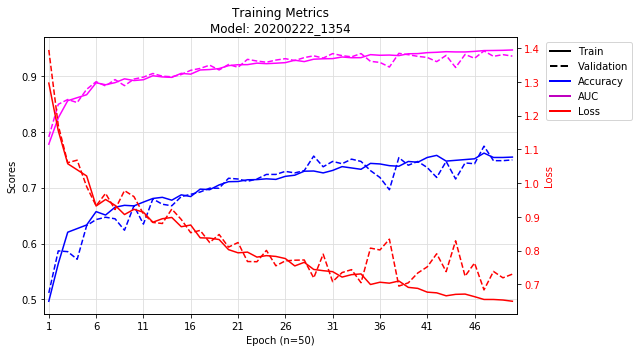

True

In [74]:
def plotHistory(history, save=False):
    """
    Plots the evalation metrics of the trained model. Included metrics are
    accuracy, AUC, and loss in both training and validation data. Optionally,
    precision and recall metrics can also be plotted.
    Input: training history object
    Output: Two subplots showing the evaluation scores w.r.t. to the epoch.

    Note: any missing key (evaluation metric) from the history.history 
    dictionary will raise an exception and the plots would not be generated.
    The first missing key will be printed as the exception.
    """
    try:
        from matplotlib.patches import Patch
        from matplotlib.lines import Line2D

        fig = plt.figure(figsize=(9, 5))

        legends = [Line2D([0], [0], color='k', lw=2, label='Train'),
                   Line2D([0], [1], ls='--', color='k', lw=2, label='Validation'),
                   Line2D([0], [0], color='b', lw=2, label='Accuracy'),
                   Line2D([0], [0], color='m', lw=2, label='AUC'),
                   Line2D([0], [0], color='r', lw=2, label='Loss'),]

        ax1 = fig.add_subplot(111)
        ax1.set_title(f'Training Metrics\nModel: {now}')
        minVal, maxVal = 1, 0
        finalEpoch = len(history.history['accuracy'])
        epoch_axis = range(1, finalEpoch+1)
        for result in history.history:
            if 'loss' not in result:
                for val in history.history[result]:
                    if val < minVal: minVal = val
                    if val > maxVal: maxVal = val
        plt.xlim((0.5, finalEpoch+0.5))
        plt.xticks(range(1, finalEpoch+1, 5))
        ax1.plot(epoch_axis, history.history['accuracy'], 
                 color='blue', label='Accuracy')
        ax1.plot(epoch_axis, history.history['AUC'], 
                 color='magenta', label='AUC')
        ax1.plot(epoch_axis, history.history['val_accuracy'], '--', 
                 color='blue', label='valAccuracy')
        ax1.plot(epoch_axis, history.history['val_AUC'], '--', 
                 color='magenta', label='valAUC')
        ax1.set_ylabel('Scores')

        ax2 = ax1.twinx()
        ax2.plot(epoch_axis, history.history['loss'], 
                 color='red', label='Training')
        ax2.plot(epoch_axis, history.history['val_loss'], '--',
                 color='red', label='Validation')
        for tl in ax2.get_yticklabels():
            tl.set_color('red')
        ax2.set_ylabel('Loss', color='red')
        ax1.set_xlabel(f'Epoch (n={finalEpoch})')
        ax1.legend(handles=legends, bbox_to_anchor=(1.05, 1.0))
        ax1.grid(color='#DDDDDD')
        plt.tight_layout()
        plt.show()
        if save:
            plt.savefig(os.path.join(PROJECT_PATH, 
                                     f'{now}.png'))
        return True
    except Exception as E:
        print ('Unable to produce figure, missing key:', E) 
        return False

plotHistory(history, False)

In [83]:
df_result = pd.DataFrame(index=['Training', 'Validation'],
                         columns=['Accuracy', 'AUC'],
                         data=[[history.history['accuracy'][-1], 
                                history.history['AUC'][-1]],
                               [history.history['val_accuracy'][-1],
                                history.history['val_AUC'][-1]]])

print ("Evaluation Statistics of the Model Trained Above")
df_result = df_result.T
df_result['delta'] = df_result['Training']-df_result['Validation']
df_result

Evaluation Statistics of the Model Trained Above


,Training,Validation,delta
Accuracy,0.754691,0.749658,0.005033
AUC,0.946378,0.935385,0.010993


In [ ]:


def saveModel(history):
    """
    Collects all information about the training and the model and saved them
    into appropriate files: .h5 for the model and .json for the evaluation 
    statistics and training data augmentation parameters.
    Input: history object, image preprocessing generator object
    Output: h5 and json files

    Note: files are saved following the pattern YYYYMMDD_HHmm (in UTC timezone).
    """
    print ("Saving model configuration and training stats...")
    try:
        df = pd.DataFrame.from_dict(history.history)
        df.to_json(os.path.join(PROJECT_PATH, f'history_{now}.json'))
    except Exception as E:
        print ('Unable to save history!')
        pass
    with open(os.path.join(PROJECT_PATH, f'{now}.json'), 'wt') as inj:
        json.dump(history.model.to_json(), inj)
    with open(os.path.join(PROJECT_PATH, f'ImgDatGen_{now}.json'), 'wt') as inj:
        tempJson = json.dumps(vars(trainGenerator))
        json.dump(tempJson, inj)
    plt.show()
    model.save(os.path.join(PROJECT_PATH, f'model_{now}.h5'))
    print (f"Model saved as model_{now}.h5")
    return True

saveModel(history)

